# Innovative Technologien und Services
### von Fabian Harmsen, Phillip Krumpholz, Till Waller
### Recommenderservice mit Python
Ziel dieser Abgabe ist es ein funktionierendes Recommenders system zu entwickeln, welches contend-based und collaborative filtering ermöglicht.


### Imports für den Recommender
Im folgenden Abschnitt werden Bibiliotheken für den Recommender importiert.

In [138]:
import pandas as pd
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split, cross_validate
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## Aufgabe 1
Im folgenden Abschnitt wird der Aufbau des contend-basted Recommenders Schritt für Schritt erläutert. Zum Abschluss werden einige Empfehlungen zu bestimmten Filmen exemplarisch ausgegeben.

### Import der CSV "metadata"
Im folgenden Abschnitt importieren wir die CSV-Dateien.

In [139]:
metadata = pd.read_csv('data/movies_metadata.csv', low_memory=False)
credits = pd.read_csv('data/credits.csv', low_memory=False)
keywords = pd.read_csv('data/keywords.csv', low_memory=False)
rating = pd.read_csv('data/ratings_small.csv', low_memory=False)

### Content based filtering und das Problem dahinter
Jeder Film hat eine Beschreibung welche wir im folgenden Abschnitt einmal exemplarisch zeigen. Das offensichtliche Problem hierbei ist die automatische Verarbeitung von natürlicher Sprache.

In [140]:
metadata.head(3)
metadata['overview'].head()

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
3    Cheated on, mistreated and stepped on, the wom...
4    Just when George Banks has recovered from his ...
Name: overview, dtype: object

### Lösung des Problems
As the name suggests, word vectors are vectorized representation of words in a document. The vectors carry a semantic meaning with it. For example, man & king will have vector representations close to each other while man & woman would have representation far from each other.

You will compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each document. This will give you a matrix where each column represents a word in the overview vocabulary (all the words that appear in at least one document), and each column represents a movie, as before.

In its essence, the TF-IDF score is the frequency of a word occurring in a document, down-weighted by the number of documents in which it occurs. This is done to reduce the importance of words that frequently occur in plot overviews and, therefore, their significance in computing the final similarity score.

From the above output, you observe that 75,827 different vocabularies or words in your dataset have 45,000 movies.

With this matrix in hand, you can now compute a similarity score. There are several similarity metrics that you can use for this, such as the manhattan, euclidean, the Pearson, and the cosine similarity scores.

### Cosine Matrix

Durch die Vektorisierung der Wörter ist es nun möglich Beschreibungen anhand der Kosinus-Ähnlichkeit (cosine similarity) zu berechnen.

Since you have used the TF-IDF vectorizer, calculating the dot product between each vector will directly give you the cosine similarity score. Therefore, you will use sklearn's linear_kernel() instead of cosine_similarities() since it is faster.

This would return a matrix of shape 45466x45466, which means each movie overview cosine similarity score with every other movie overview. Hence, each movie will be a 1x45466 column vector where each column will be a similarity score with each movie.


In [141]:
def getCosineMatrixDescription(metadata):
    # Vektorisieren der Beschreibung
    tfidf = TfidfVectorizer(stop_words='english')
    metadata['overview'] = metadata['overview'].fillna('')
    tfidf_matrix = tfidf.fit_transform(metadata['overview'])
    print(tfidf_matrix.shape)

    # Bildung der Matrix
    cosine_matrix = linear_kernel(tfidf_matrix, tfidf_matrix)
    print(cosine_matrix.shape)
    return cosine_matrix

In [142]:
def get_director(x):
        for i in x:
            if i['job'] == 'Director':
                return i['name']
        return np.nan

In [143]:
def get_list(x):
        if isinstance(x, list):
            names = [i['name'] for i in x]
            # Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
            if len(names) > 3:
                names = names[:3]
            return names

        # Return empty list in case of missing/malformed data
        return []

In [144]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
        if isinstance(x, list):
            return [str.lower(i.replace(" ", "")) for i in x]
        else:
            # Check if director exists. If not, return empty string
            if isinstance(x, str):
                return str.lower(x.replace(" ", ""))
            else:
                return ''

In [145]:
def create_soup(x):
        return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])

In [146]:
def getCosineMatrixAttributes(metadata, keywords, credits):
    # Convert IDs to int. Required for merging
    keywords['id'] = keywords['id'].astype('int')
    credits['id'] = credits['id'].astype('int')
    metadata['id'] = metadata['id'].astype('int')

    # Merge keywords and credits into your main metadata dataframe
    metadata = metadata.merge(credits, on='id')
    metadata = metadata.merge(keywords, on='id')

    # Print the first two movies of your newly merged metadata
    print(metadata.head(2))

    features = ['cast', 'crew', 'keywords', 'genres']
    for feature in features:
        metadata[feature] = metadata[feature].apply(literal_eval)

    # Define new director, cast, genres and keywords features that are in a suitable form.
    metadata['director'] = metadata['crew'].apply(get_director)

    features = ['cast', 'keywords', 'genres']
    for feature in features:
        metadata[feature] = metadata[feature].apply(get_list)

    # Print the new features of the first 3 films
    print(metadata[['title', 'cast', 'director', 'keywords', 'genres']].head(3))

    # Apply clean_data function to your features.
    features = ['cast', 'keywords', 'director', 'genres']

    for feature in features:
        metadata[feature] = metadata[feature].apply(clean_data)

    # Create a new soup feature
    metadata['soup'] = metadata.apply(create_soup, axis=1)

    print(metadata[['soup']].head(2))

    count = CountVectorizer(stop_words='english')
    count_matrix = count.fit_transform(metadata['soup'])

    print(count_matrix.shape)

    return cosine_similarity(count_matrix, count_matrix)    # Remove rows with bad IDs.


### Index-Mapping
Die Funktion index_mapping ist eine pd.Series-Instanz, die aus der Metadaten-Tabelle erstellt wurde. Die pd.Series enthält den Index jedes Films als Wert und den Titel jedes Films als Index. Dies wird erreicht, indem der Index der Metadaten-Tabelle als Wert und der Titel als Index übergeben wird.

Die .drop_duplicates()-Methode wird aufgerufen, um alle Duplikate aus der pd.Series zu entfernen. Wenn mehrere Filme den gleichen Titel haben, wird nur der erste Film in der pd.Series gespeichert.

Anschließend wird ein Teil der pd.Series mithilfe des Subset-Operators [:5] ausgegeben. Dies gibt die ersten fünf Einträge zurück.

In [147]:
def getIndexMapping (metadata):
    index_mapping = pd.Series(metadata.index, index=metadata['title']).drop_duplicates()
    print(index_mapping[:5])
    return index_mapping

### Funktion
You're going to define a function that takes in a movie title as an input and outputs a list of the 10 most similar movies

In [148]:
def recommend_films_by_content(title, n, cosine_matrix_description, index_mapping, metadata):
    index = index_mapping[title]

    score = list(enumerate(cosine_matrix_description[index]))

    score = sorted(score, key=lambda x: x[1], reverse=True)

    score = score[1:n]

    movie_indices = [i[0] for i in score]

    return metadata['title'].iloc[movie_indices]

In [149]:
df_metadata = metadata.drop([19730, 29503, 35587])

title = 'The Dark Knight Rises'
cosine_matrix_description = getCosineMatrixDescription(df_metadata)
cosine_matrix_attributes = getCosineMatrixAttributes(df_metadata, keywords, credits)
index_mapping = getIndexMapping(df_metadata)

recommend_films_by_content(title, 11, cosine_matrix_description, index_mapping, metadata)
recommend_films_by_content(title, 11, cosine_matrix_attributes, index_mapping, metadata)

(45463, 75827)
(45463, 45463)
   adult                              belongs_to_collection    budget  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1  False                                                NaN  65000000   

                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   

                               homepage    id    imdb_id original_language  \
0  http://toystory.disney.com/toy-story   862  tt0114709                en   
1                                   NaN  8844  tt0113497                en   

  original_title                                           overview  ...  \
0      Toy Story  Led by Woody, Andy's toys live happily in his ...  ...   
1        Jumanji  When siblings Judy and Peter discover an encha...  ...   

                                    spoken_languages    status  \
0           [{'iso_639_1': 'en', 'name': 'English'}

44509                             White Dew
27803    Lightning Bolt: The Power Of Salad
26241                   Wicked as They Come
24174                                Spasmo
25865                    Terminator Genisys
32020                         The Scapegoat
23166                  When Jews Were Funny
23294                      Age of Dinosaurs
27378             The Legend of Bloody Mary
40741                          The Seahorse
Name: title, dtype: object

## Aufgabe 2
Im folgenden Abschnitt wird der Aufbau des collaborative Recommenders Schritt für Schritt erläutert. Zum Abschluss werden einige Empfehlungen zu bestimmten Filmen exemplarisch ausgegeben.

### Neuformartierung Movie Metadata
Diese Funktion bereitet einen DataFrame von Filmmetadata auf. Sie nimmt einen DataFrame mit allen Filmmetadata (df_mmeta_local) als Eingabe und gibt einen neuen, formatierten DataFrame (df_movies_local) zurück.
Zunächst wird aus dem Release-Datum des Films das Erscheinungsjahr extrahiert und in einer neuen Spalte year im DataFrame gespeichert. Wenn das Release-Datum fehlt oder nicht konvertiert werden kann, wird der Wert NaN verwendet.
Anschließend wird die Spalte genres des Eingabedatensatzes extrahiert und auf ihren Inhalt (Liste von Genres) transformiert. Die Spalte genres wird dann in eine Liste von Genrenamen konvertiert.
Der Index des DataFrames wird dann auf die Spalte movieId geändert und auf numerische Werte konvertiert.
Danach wird die Spalte vote_count aus dem Eingabedatensatz extrahiert und in den neuen DataFrame eingefügt. Der Datentyp von vote_count wird auf Integer konvertiert.
Schließlich wird auch der Titel des Films in den neuen DataFrame eingefügt.
Der neu formatierte DataFrame wird schließlich zurückgegeben.

In [150]:
def getDfMovies(df_meta_local):

    df_movies_local = pd.DataFrame()
    # extract the release year
    df_movies_local['year'] = pd.to_datetime(df_meta_local['release_date'], errors='coerce').apply(
        lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

    # extract genres
    df_movies_local['genres'] = df_meta_local['genres'].fillna('[]').apply(literal_eval).apply(
        lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

    # change the index to movie_id
    df_movies_local['movieId'] = pd.to_numeric(df_meta_local['id'])
    df_movies_local = df_movies_local.set_index('movieId')

    # add vote count
    ##FH 2022-11-27 Correction getting Votes from df_mmeta
    df_movies_local['vote_count'] = df_meta_local['vote_count']
    df_movies_local['vote_count'] = df_movies_local['vote_count'].astype('int', True, 'ignore')
    ##FH 2022-11-27 Added getting title
    df_movies_local['title'] = df_meta_local["title"]
    return df_movies_local

### Trainieren und validieren des Collaborations-Modells
Diese Funktion trainiert und validiert ein Collaborative Filtering-Modell für Vorhersage von Bewertungen von Filmen durch Benutzer. Der Code nutzt das Python-Modul Surprise für Collaborative Filtering.
Zunächst werden fehlende Werte (NaN) aus dem Eingabedatensatz entfernt. Danach wird der Zeitstempel in der Spalte timestamp in ein datetime-Format konvertiert.
Anschließend wird das Reader-Modul von Surprise verwendet, um den Datensatz zu analysieren und in eine Dataset-Instanz zu laden. Der Datensatz enthält Benutzer-ID, Film-ID und Bewertung in Spalten userId, movieId und rating.
Der Datensatz wird dann in einen Trainings- und einen Testsatz aufgeteilt. Das Verhältnis wird durch den Wert von test_size festgelegt, in diesem Fall 20%.
Danach wird ein SVD-Modell (Singular Value Decomposition) von Surprise instanziiert und mit dem Trainingsdatensatz trainiert.
Schließlich wird das trainierte Modell mithilfe der Funktion cross_validate von Surprise validiert. Dabei wird der komplette Datensatz in 10 Fälle aufgeteilt und das Modell 10-fach über alle Fälle validiert. Als Messgrößen werden der Root Mean Squared Error (RMSE), der Mean Absolute Error (MAE) und der Mean Squared Error (MSE) berechnet.
Die Funktion gibt schließlich das trainierte und validierte SVD-Modell zurück. Zusätzlich wird ein Balkendiagramm erstellt, das den MAE für jeden Durchlauf der Cross-Validation anzeigt.

In [151]:
def trainAndValidateCollaboration(df_ratings_local):

    # drop na values
    df_ratings_temp = df_ratings_local.dropna()
    # convert datetime
    df_ratings_temp['timestamp'] = pd.to_datetime(df_ratings_temp['timestamp'], unit='s')

    # The Reader class is used to parse a file containing ratings.
    # The file is assumed to specify only one rating per line, such as in the df_ratings_temp file above.
    reader = Reader()
    ratings_by_users = Dataset.load_from_df(df_ratings_temp[['userId', 'movieId', 'rating']], reader)

    # Split the Data into train and test
    train_df, test_df = train_test_split(ratings_by_users, test_size=.2)

    # train an SVD model
    svd_model = SVD()
    svd_model_trained = svd_model.fit(train_df)

    # 10-fold cross validation
    cross_val_results = cross_validate(svd_model_trained, ratings_by_users, measures=['RMSE', 'MAE', 'MSE'], cv=10,
                                       verbose=False)
    test_mae = cross_val_results['test_mae']

    # mean squared errors per fold
    df_test_mae = pd.DataFrame(test_mae, columns=['Mean Absolute Error'])
    df_test_mae.index = np.arange(1, len(df_test_mae) + 1)
    df_test_mae.sort_values(by='Mean Absolute Error', ascending=False).head(15)

    # plot an overview of the performance per fold
    plt.figure(figsize=(6, 4))
    sns.set_theme(style="whitegrid")
    sns.barplot(y='Mean Absolute Error', x=df_test_mae.index, data=df_test_mae, color="b")
    plt.title('Mean Absolute Error')

    return svd_model_trained

### Empfehle Filme
Diese Funktion empfiehlt Filme für einen gegebenen Benutzer basierend auf Vorhersagen des Bewertungen mithilfe eines Collaborative Filtering-Modells und den von diesem Benutzer bereits bewerteten Filmen.
Zunächst wird der gewählte Film angezeigt, indem der DataFrame df_movies_local nach dem angegebenen Titel durchsucht wird. Der Film wird dann anhand seines Erscheinungsjahrs gefiltert und der DataFrame df_movies_local wird auf Filme aus dem gleichen Jahr beschränkt.
Danach wird der DataFrame df_ratings nach Bewertungen des angegebenen Benutzers gefiltert und die Anzahl der Bewertungen wird ausgegeben.
Schließlich wird für jeden Film in df_movies_local eine Vorhersage der Bewertung durch den Benutzer mithilfe des übergebenen, trainierten Collaborative Filtering-Modells berechnet. Die Vorhersagen werden in einem DataFrame df_recommendations zusammengefasst, der die Filme mit ihren vorhergesagten und tatsächlichen Bewertungen enthält. Schließlich wird der DataFrame sortiert und die empfohlenen Filme werden anhand der vorhergesagten Bewertungen absteigend angezeigt. Die Anzahl der empfohlenen Filme wird durch den Wert von n festgelegt.

In [152]:
def recommend_films_by_collaboration(title, n, user_id, svd_model_trained, df_movies_local, df_ratings):

    chosenMovie = df_movies_local[df_movies_local['title'] == title]
    year = chosenMovie["year"].iloc[0]

    #filter by Year
    df_movies_local = df_movies_local[df_movies_local['year'] == year]

    df_ratings_filtered = df_ratings[df_ratings['userId'] == user_id]

    pred_series = []
    for movie_id, name in zip(df_movies_local.index, df_movies_local['title']):
        rating_pred = svd_model_trained.predict(user_id, movie_id, 0, verbose=False)
        pred_series.append([movie_id, name, rating_pred.est, 0])
    df_recommendations = pd.DataFrame(pred_series, columns=['movieId', 'title', 'predicted_rating', 'actual_rating'])
    display(df_recommendations.sort_values(by='predicted_rating', ascending=False).head(n))

### Funktion
Dieser Code empfiehlt Filme für einen gegebenen Benutzer anhand von Vorhersagen mithilfe von Collaborative Filtering.

Zunächst wird der DataFrame mit Filmmetadaten mithilfe der Funktion getDfMovies aufbereitet und in der Variablen df_movies gespeichert. Anschließend wird ein Collaborative Filtering-Modell mithilfe der Funktion trainAndValidateCollaboration trainiert und in der Variablen svd_model_trained gespeichert.
Danach werden die Variablen title, user_id und n definiert, die den Titel des zu empfehlenden Films, die Benutzer-ID des Benutzers und die Anzahl der empfohlenen Filme angeben.
Schließlich wird die Funktion recommend_films_by_collaboration aufgerufen und die Variablen title, n, user_id, svd_model_trained und df_movies werden als Argumente übergeben. Die Funktion empfiehlt Filme für den gegebenen Benutzer und gibt eine Liste von empfohlenen Filmen aus, sortiert nach ihren vorhergesagten Bewertungen.

,movieId,title,predicted_rating,actual_rating
301,31410,Sugar,4.191912,0
254,44191,Revengeance,4.059768,0
34,8879,The Unknown Soldier,4.012166,0
135,1884,Child's Play 3,3.969879,0
38,1374,Turbulence,3.935513,0
48,1694,U.S. Marshals,3.846909,0
244,32387,29th and Gay,3.843400,0
205,26974,House Party 4: Down to the Last Minute,3.810916,0
289,58191,NaN,3.783086,0
280,105246,NaN,3.727616,0


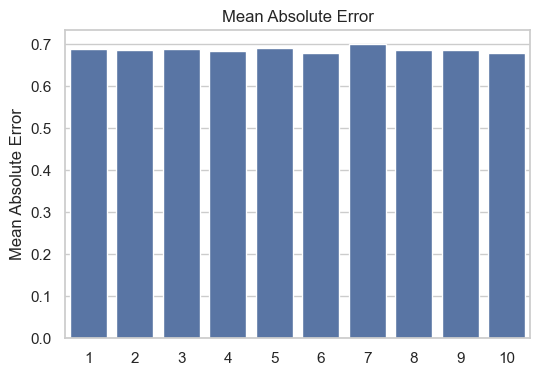

In [153]:
# remove invalid records with invalid ids
df_meta = metadata.drop([19730, 29503, 35587])

df_movies = getDfMovies(df_meta)
svd_model_trained = trainAndValidateCollaboration(rating)

title = 'The Dark Knight Rises'
user_id = 400
n = 10

recommend_films_by_collaboration(title, n, user_id, svd_model_trained, df_movies, rating)

In [154]:
df_metadata = metadata.drop([19730, 29503, 35587])
user_id = 400
n = 10
title = 'The Dark Knight Rises'
cosine_matrix_description = getCosineMatrixDescription(df_metadata)
index_mapping = getIndexMapping(df_metadata)

# remove invalid records with invalid ids

df_movies = getDfMovies(recommend_films_by_content(title, 100, cosine_matrix_description, index_mapping, metadata))
svd_model_trained = trainAndValidateCollaboration(rating)

recommend_films_by_collaboration(title, n, user_id, svd_model_trained, df_movies, rating)

(45463, 75827)
(45463, 45463)
title
Toy Story                      0
Jumanji                        1
Grumpier Old Men               2
Waiting to Exhale              3
Father of the Bride Part II    4
dtype: int64


KeyError: 'release_date'